In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import datetime
import csv
import math
import time
from ProgressBar import ProgressBar
import cPickle
import scipy


import nltk
import string
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/kshain/anaconda/envs/AC209/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<hr width=80%>
# <center> Data Cleaning & Bigrams</center>
<hr width=80%>

* ### [Data Cleaning](#Data-Cleaning)
    * [Loading the data](#Loading-the-data)
    * [Removing missing data](#Removing-missing-data)
    * [Adding 'yearmonth'](#Article-Search-API)
    * [Stemming](#Stemming)
* ### [Extracting Unigrams and Bigrams](#Extracting-Unigrams-and-Bigrams)
    * [Getting the count of all bigrams](#Getting-the-count-of-all-bigrams)
    * [Calculating Dunning Log-Likelihood Ratio](#Calculating-Dunning-Log-Likelihood-Ratio)
    * [Using the Bigram Vocabulary](#Using-the-Bigram-Vocabulary)
    * [Count Vectorizing](#Count-Vectorizing)
* ### [Monthly Aggregates](#Monthly-Aggregates)

## Data Cleaning

### Loading the data

We will load all of our data files from the API calls and put them into a single dataframe. This covers 1990 through 2016.

In [2]:
all_data_list = []
for year in range(1990,2017):
    data = pd.read_csv('{}_Output.csv'.format(year), header=None)
    all_data_list.append(data) # list of dataframes
data = pd.concat(all_data_list, axis=0)
data.columns = ['id','date','headline', 'lead']
data.head()

,id,date,headline,lead
0,4fd1aa888eb7c8105d6c860e,1990-01-03T00:00:00Z,Tandem Expected To Show Computer,LEAD: Tandem Computers Inc. is expected to int...
1,52b85b7738f0d8094087c782,1990-01-03T00:00:00Z,Chrysler Shows Van Concept,LEAD: The Chrysler Corporation today introduce...
2,52b85b7638f0d8094087c780,1990-01-02T00:00:00Z,Loan Pact Seen For Hungary,LEAD: Hungary expects to complete a deal with ...
3,52b85b7538f0d8094087c77f,1990-01-02T00:00:00Z,Counterattack Planned By Lawyers for Lincoln,"LEAD: Lawyers for Charles H. Keating Jr., who ..."
4,4fd18d4c8eb7c8105d691815,1990-01-08T00:00:00Z,Intermetrics Inc reports earnings for Qtr to N...,LEAD: *3*** COMPANY REPORTS ** *3* Intermetric...


### Removing missing data

By inspection, we see that the data is remarkably clean. There are almost no changes that need to be made, except for removing a few articles that do not have lead paragraphs. This is only ~500 articles out of ~500,000.

In [3]:
data.shape

(578151, 4)

In [4]:
data.dropna(inplace=True)

In [5]:
data.shape

(577624, 4)

### Adding 'yearmonth'

We add a column that uniquely identifies just the month and year of each article. This is useful because we will be aggregating by month several times later on.

In [6]:
data['yearmonth'] = map(lambda x: x[:7], data.date)

### Stemming

The lead paragraphs are then tokenized and stemmed. Tokenizing just makes an ordered list of words from each lead paragraph and removes punctuation. The stemming removes suffixes like the plural “s” or past “ed” which we hypothesize not to have semantic importance. Lastly, we add the stemmed lead paragraphs to the dataframe.

In [7]:
def getStems(lead):
    stemmer = nltk.stem.SnowballStemmer("english")
    tokens = nltk.word_tokenize(''.join(ch for ch in lead if ch not in set(string.punctuation)))
    return map(lambda x: stemmer.stem(x.decode('utf-8')), tokens)

In [8]:
def joinstems(stemlist):
    return ' '.join(stem for stem in stemlist)

In [9]:
stems = map(getStems, data.lead)

In [10]:
data['leadstems'] = map(joinstems, stems)

In [11]:
data.head()

,id,date,headline,lead,yearmonth,leadstems
0,4fd1aa888eb7c8105d6c860e,1990-01-03T00:00:00Z,Tandem Expected To Show Computer,LEAD: Tandem Computers Inc. is expected to int...,1990-01,lead tandem comput inc is expect to introduc n...
1,52b85b7738f0d8094087c782,1990-01-03T00:00:00Z,Chrysler Shows Van Concept,LEAD: The Chrysler Corporation today introduce...,1990-01,lead the chrysler corpor today introduc a futu...
2,52b85b7638f0d8094087c780,1990-01-02T00:00:00Z,Loan Pact Seen For Hungary,LEAD: Hungary expects to complete a deal with ...,1990-01,lead hungari expect to complet a deal with the...
3,52b85b7538f0d8094087c77f,1990-01-02T00:00:00Z,Counterattack Planned By Lawyers for Lincoln,"LEAD: Lawyers for Charles H. Keating Jr., who ...",1990-01,lead lawyer for charl h keat jr who head the b...
4,4fd18d4c8eb7c8105d691815,1990-01-08T00:00:00Z,Intermetrics Inc reports earnings for Qtr to N...,LEAD: *3*** COMPANY REPORTS ** *3* Intermetric...,1990-01,lead 3 compani report 3 intermetr inc otc qtr ...


## Extracting Unigrams and Bigrams

Unigrams are single words without context. Using CountVectorizer it is straightforward to extract the unigrams that occur in at least 0.5% of articles and less than 80% of articles.

Beyond unigrams, we also speculate that co-occurrence of words is relevant in business articles. For example, “unemployment fell” includes two words that independently are negative, but together are positive. Therefore, we also want to extract bigrams, pairs of words that appear consecutively. However, there are many more bigrams than unigrams as unigrams are limited to the size of the dictionary and bigrams are limited to that number squared. To reduce the dimension, we only use bigrams where the two words are much more likely to occur together than separately based on the [Dunning Log-Likelihood Ratio](#http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=6EB3C415737C0A93B117F08A4BEC9B72?doi=10.1.1.14.5962&rep=rep1&type=pdf)(DLLR). 

The essence of the DLLR statistic is that it measures how much more likely two words occur consecutively than would be expected by chance. As expected, this statistic takes as inputs the number of times the constituent words occur together and separately.

### Getting the count of all bigrams

The first step is to extract all of the bigram stems from the entire dataset using the appropriate function from `nltk`. Then, we put all bigrams regardless of article into a list and count the number of times that each unique bigram occurs.

In [12]:
def getBigrams(stems):
    stems = stems.split()
    finder = nltk.collocations.BigramCollocationFinder.from_words(stems)
    return(finder.ngram_fd.items())

In [15]:
bigramList = map(getBigrams, data.leadstems)

In [16]:
flatBigrams = [item for sublist in bigramList for item in sublist]

In [17]:
def reduceByKey(toIterate): # For us, the bigram is the key
    d = defaultdict(int)
    for i, (key, value) in enumerate(toIterate):
        d[key] += value
    return list(d.items())

In [18]:
summedBigrams = reduceByKey(flatBigrams)

It's useful to be able to save and load this result since it takes a few minutes to run.

In [212]:
with open("summedBigrams.pkl", "wb") as output_file:
    pickle.dump(summedBigrams, output_file)

In [213]:
with open("summedBigrams.pkl", "rb") as input_file:
    summedBigrams2 = pickle.load(input_file)

### Calculating Dunning Log-Likelihood Ratio

It is not important to go into the details of the calculations, but we use a few nested functions to keep all of the logs from getting messy. In the literature, the notation used is,
$$k_{11}=N(A,B)$$
$$k_{12}=N(A,not B)$$
$$k_{21}=N(not A,B)$$
$$k_{22}=N(not A,not B)$$
Where $N(A,B)$ is the number of times the bigram "A B" occurs.

In [14]:
def xLogX(x):
    if x==0:
        return 0
    else:
        return x * np.log(x)
    
def entropy(things):
    theSum = 0
    theResult = 0
    for thing in things:
        theResult += xLogX(thing)
        theSum += thing;

    return xLogX(theSum) - theResult;

def logLikelihoodRatio(k11, k12, k21, k22):
    rowEntropy = entropy([k11 + k12, k21 + k22]);
    columnEntropy = entropy([k11 + k21, k12 + k22]);
    matrixEntropy = entropy([k11, k12, k21, k22]);
    return(2.0 * (rowEntropy + columnEntropy - matrixEntropy))

def getLLR(summedBigram):
    k11 = summedBigram[1]
    stem1 = summedBigram[0][0]
    stem2 = summedBigram[0][1]
    k12 = bigrams1Dict[stem1] - k11
    k21 = bigrams2Dict[stem2] - k11
    k22 = totalBigrams - k11 - k12 - k21
    return(logLikelihoodRatio(k11, k12, k21, k22))

It is also useful to have a dictionary of the number of times each word appears in any general bigram so that we can find the $N(A, not\,B)$ and like terms

In [19]:
bigrams1 = map(lambda x: (x[0][0], x[1]), summedBigrams)
summedBigrams1= reduceByKey(bigrams1)

In [20]:
bigrams2 = map(lambda x: (x[0][1], x[1]), summedBigrams)
summedBigrams2= reduceByKey(bigrams2)

In [21]:
bigrams1Dict = dict(summedBigrams1)
bigrams2Dict = dict(summedBigrams2)

In [22]:
onlyValues = np.array(map(lambda x: x[1], summedBigrams))
totalBigrams = onlyValues.sum()

Finally, we can get the DLLR statistic for each bigram.

In [23]:
LLRs = map(getLLR, summedBigrams)

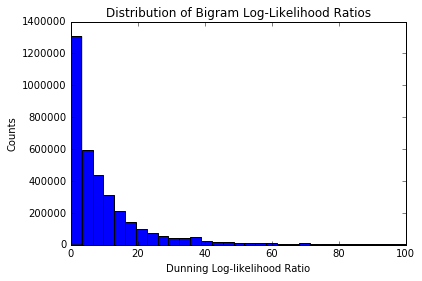

In [26]:
plt.hist(LLRs, bins=200000);
plt.xlim((0,100))
plt.xlabel('Dunning Log-likelihood Ratio')
plt.ylabel('Counts')
plt.title('Distribution of Bigram Log-Likelihood Ratios')

In [28]:
print 'Most likely bigram: {}'.format(np.array(summedBigrams)[np.argmax(np.array(LLRs))][0])

Most likely bigram: (u'new', u'york')


Just as a sanity check, it is good to note that "New York" is most likely to be a bigram according to our metric. This makes sense as "New" and "York" are way more likely to occur together than separately, especially in the New York Times.

Lastly, we have done a lot of computation so we can save the results.

In [29]:
justBigrams = map(lambda x: x[0], summedBigrams)
bigramLLR = zip(justBigrams,LLRs)

In [235]:
with open("bigramLLR.pkl", "wb") as output_file:
    cPickle.dump(bigramLLR, output_file)

In [65]:
with open("bigramLLR.pkl", "rb") as input_file:
    bigramLLR = cPickle.load(input_file)

### Using the Bigram Vocabulary

Choosing the minimum DLLR threshold for inclusion in our bigram vocabulary is a bit arbitrary, but we can set it such that we have a reasonable number of bigrams in our final vocab. With some testing, 1500 is a good threshold.

In [30]:
bigramVocab = np.array(summedBigrams)[list(np.where(np.array(LLRs)>1500)[0])]

In [31]:
len(bigramVocab)

8626

Much like with unigrams, it makes sense to eliminate bigrams that contain stopwords as those are not likely to have any meaning in our future analysis.

In [32]:
stopwords = ['or','the','a','an','and','as','at','it','this','that','he','I','she','of','is','was','are','be','did','do','has','had','have','with','for','from', 'to', 'on', 'in', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'yesterday', 'tomorrow','year']

In [33]:
bigramVocab = [bigram for bigram in bigramVocab if (set(bigram[0]).isdisjoint(stopwords))]

Lastly, we will stitch together just the stems from the bigram vocabulary list so that they are exactly how they will appear in the stemmed lead paragraphs.

In [34]:
bigramVocab = map(lambda x: x[0][0]+' '+x[0][1], list(bigramVocab))

### Count Vectorizing

We seek to extract the number of times each unigram and bigram of interest appears in each article. We already have a bigram vocabulary, but we need to create a unigram vocabulary by doing a first pass with the count vectorizer only looking for unigrams.

In [35]:
countVec = CountVectorizer(stop_words='english', max_df=0.8, min_df=.005, strip_accents='unicode')
wordMatrix = countVec.fit_transform(data.leadstems)
unigramVocab = countVec.get_feature_names()

In [36]:
totalVocab = unigramVocab + bigramVocab

The, we can do a count vectorizer that takes as an argument the particular vocabulary that we are looking for.

In [37]:
countVecAll = CountVectorizer(ngram_range = (1,2), vocabulary = totalVocab)
wordMatrix = countVecAll.fit_transform(data.leadstems)

We also made a couple of helper functions to save and load the sparse arrays that come out of the count vectorizer.

In [38]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return scipy.sparse.csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [149]:
save_sparse_csr('bigramWordMatrix.npz',wordMatrix)

## Monthly Aggregates

As the final step, we can make monthly aggregates of the unigrams and bigrams outputted by the count vectorizer. It is possible that we will still want to use the granular article level data, but the monthly aggregates will turn out to be very useful.

In [39]:
grouped = data.groupby('yearmonth')

In [40]:
wordsByMonth = np.zeros((len(grouped.groups.keys()),wordMatrix.shape[1]))
for i, month in enumerate(np.sort(grouped.groups.keys())):
    wordsByMonth[i] = np.sum(wordMatrix[grouped.get_group(month).index], axis=0)

As an example of the monthly counts by word, we can see how often "America" appears

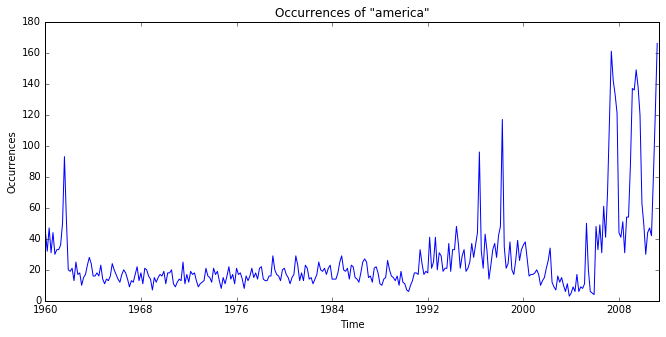

In [98]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(111)
ax.plot(range(len(grouped)),wordsByMonth[:,103])
ax.set_title('Occurrences of "{}"'.format(totalVocab[103]))
ax.set_ylabel('Occurrences')
ax.set_xlabel('Time')
ax.set_xlim((0,len(grouped)))
ax.set_xticklabels(list(np.arange(1960,2018,8)));